<ipython-input-53-4bc817bd4a74>:24: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


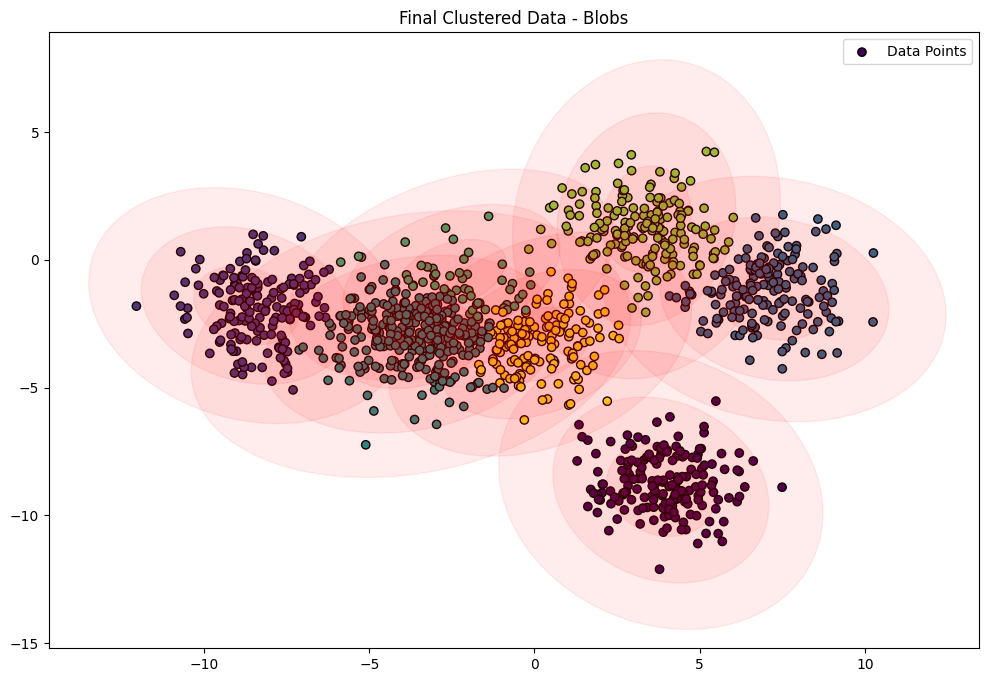

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from matplotlib.patches import Ellipse
from scipy.spatial.distance import pdist, squareform

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def apply_clustering(X, n_components=5, n_clusters=2):
    # Fit a Gaussian Mixture Model to find the cluster centers and their covariances
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X)
    means = gmm.means_
    covariances = gmm.covariances_

    # Use Spectral Clustering on the means
    dist_matrix = squareform(pdist(means, 'euclidean'))
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed_nearest_neighbors',
                                    n_neighbors=9, assign_labels='kmeans', random_state=0)
    mean_labels = clustering.fit_predict(dist_matrix)

    # Aggregate covariances by cluster
    aggregated_covs = []
    for i in range(n_clusters):
        cluster_cov = np.sum([covariances[j] for j in range(len(means)) if mean_labels[j] == i], axis=0)
        aggregated_covs.append(cluster_cov)

    # Map cluster labels back to the original data points
    labels = gmm.predict(X)
    final_labels = np.array([mean_labels[label] for label in labels])

    return final_labels, means, mean_labels, aggregated_covs

def plot_data(X, labels, means, mean_labels, aggregated_covs, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', label='Data Points')

    # Plot aggregated covariances for each cluster
    for i, cov in enumerate(aggregated_covs):
        cluster_mean = np.mean([means[j] for j in range(len(means)) if mean_labels[j] == i], axis=0)
        draw_ellipse(cluster_mean, cov, alpha=0.07, color='red')

    plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

# Generate datasets
datasets = {
    'Blobs': make_blobs(n_samples=1200, centers=7, cluster_std=1.2, random_state=500),
#     'Moons': make_moons(n_samples=300, noise=0.1, random_state=0),
}

# Parameters for the clustering
n_components = 60  # Number of GMM components
n_clusters = 7    # Number of clusters to form from the means

# Apply clustering to each dataset
for name, (X, _) in datasets.items():
    labels, means, mean_labels, aggregated_covs = apply_clustering(X, n_components=n_components, n_clusters=n_clusters)
    plot_data(X, labels, means, mean_labels, aggregated_covs, f'Final Clustered Data - {name}')
